In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn import tree, metrics
from IPython.display import Image  
import pydotplus

from xgboost import XGBClassifier, cv, plot_importance
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, roc_auc_score, f1_score, precision_recall_curve, accuracy_score, confusion_matrix, balanced_accuracy_score
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline


from sklearn.metrics import fbeta_score, make_scorer

import itertools

import warnings
warnings.filterwarnings('ignore')

from imblearn.under_sampling import RandomUnderSampler

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.compose import ColumnTransformer

import datetime

import pickle
from sklearn.inspection import permutation_importance


In [77]:
SavePath = "C:\\Users\\somfl\\Documents\\Data Science Career Track\\LendingClub\\LendingClubClean.csv"
df = pd.read_csv(SavePath, sep=',', index_col=0)

In [78]:
df.head(4)

,dti,chargeoff_within_12_mths,collections_12_mths_ex_med,inq_last_6mths,open_acc,mort_acc,annual_inc,sub_grade,loan_status,installment,...,revol_bal,emp_length,home_ownership,num_rev_accts,pub_rec_bankruptcies,tax_liens,loan_amnt,Credit Length (year),fico_score,grade
revol_util,,,,,,,,,,,,,,,,,,,,,
29.7,5.91,0.0,0.0,1.0,7.0,1.0,55000.0,C4,Fully Paid,123.03,...,2765.0,10 years up,MORTGAGE,9.0,0.0,0.0,3600.0,12.334271,677.0,C
19.2,16.06,0.0,0.0,4.0,22.0,4.0,65000.0,C1,Fully Paid,820.28,...,21470.0,10 years up,MORTGAGE,27.0,0.0,0.0,24700.0,16.000329,717.0,C
64.5,25.37,0.0,0.0,3.0,12.0,6.0,104433.0,F1,Fully Paid,289.91,...,21929.0,3 years,MORTGAGE,19.0,0.0,0.0,10400.0,17.500702,697.0,F
68.4,10.20,0.0,0.0,0.0,5.0,0.0,34000.0,C3,Fully Paid,405.18,...,8822.0,4 years,RENT,4.0,0.0,0.0,11950.0,28.167587,692.0,C


In [79]:
df.columns

Index(['dti', 'chargeoff_within_12_mths', 'collections_12_mths_ex_med',
       'inq_last_6mths', 'open_acc', 'mort_acc', 'annual_inc', 'sub_grade',
       'loan_status', 'installment', 'int_rate', 'term', 'revol_bal',
       'emp_length', 'home_ownership', 'num_rev_accts', 'pub_rec_bankruptcies',
       'tax_liens', 'loan_amnt', 'Credit Length (year)', 'fico_score',
       'grade'],
      dtype='object')

In [98]:
df['loan_status'].unique()

array(['Fully Paid', 'Default'], dtype=object)

In [99]:
df['status'] = 0
df.loc[df['loan_status']=='Default', 'status'] = 1

## Preprocessing

In [100]:
categorical_columns = ['grade', 'term', 'emp_length', 'home_ownership']
numerical_columns = [ 'dti', 'chargeoff_within_12_mths', 'collections_12_mths_ex_med', 'inq_last_6mths', 
                     'open_acc', 'mort_acc', 'annual_inc', 'installment', 'int_rate', 'revol_bal', 'num_rev_accts',
                     'pub_rec_bankruptcies', 'tax_liens', 'loan_amnt', 'Credit Length (year)', 'fico_score']

y = df['status']
X = df[numerical_columns + categorical_columns]

X_cols = X.columns
y_col = ['status']

# Undersample
Xn = X.to_numpy()
yn = y.to_numpy()
random_state=42
RU = RandomUnderSampler()
X_res, y_res = RU.fit_resample(Xn,yn)

X_res = pd.DataFrame(X_res, columns = X_cols)
y_res = pd.DataFrame(y_res, columns = y_col)

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, stratify=y_res, test_size=0.25, random_state=42)

categorical_pipe = Pipeline(steps=[('encoder', OneHotEncoder(drop='if_binary'))])
numerical_pipe = Pipeline(steps=[('scaler', MinMaxScaler())])

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_pipe, categorical_columns),
        ("num", numerical_pipe, numerical_columns),
    ]
)


In [102]:
X.shape

(1275697, 20)

In [103]:
pipeXG = Pipeline(
    [
        ("preprocess", preprocessing),
        ("classifier", XGBClassifier(random_state=42))
    ]
)

In [104]:
cv_results = cross_validate(pipeXG, X_train, y_train, scoring = 'balanced_accuracy', cv=5)
cv_scores = cv_results['test_score']
print(cv_scores)
print(cv_scores.mean(), cv_scores.std())

[23:33:43] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:34:03] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:34:22] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:34:40] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [105]:
parameters = {
    'classifier__max_depth':[3, 6],
    'classifier__learning_rate': [ 0.2, 0.1],
    }
grid_search = GridSearchCV(pipeXG, param_grid= parameters, cv=5, scoring='balanced_accuracy')
grid_search.fit(X_train,y_train)

[23:36:25] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:36:36] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:36:48] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:36:59] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(drop='if_binary'))]),
                                                                         ['grade',
                                                                          'term',
                                                                          'emp_length',
                                                                          'home_ownership']),
                                                                        ('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['dti',
                                                                          'chargeoff_within_12_mths',
                                                                          'collections_12_mths_ex_med',
                                                                          'inq_last_6mths',
                                                                          'open_acc',
                                                                          '...
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42,
                                                      reg_alpha=None,
                                                      reg_lambda=None,
                                                      scale_pos_weight=None,
                                                      subsample=None,
                                                      tree_method=None,
                                                      validate_parameters=None,
                                                      verbosity=None))]),
             param_grid={'classifier__learning_rate': [0.2, 0.1],
                         'classifier__max_depth': [3, 6]},
             scoring='balanced_accuracy')

In [106]:
# Print best parameters and results
print(grid_search.best_params_)
print(grid_search.best_score_)

{'classifier__learning_rate': 0.2, 'classifier__max_depth': 6}
0.6622834430354578


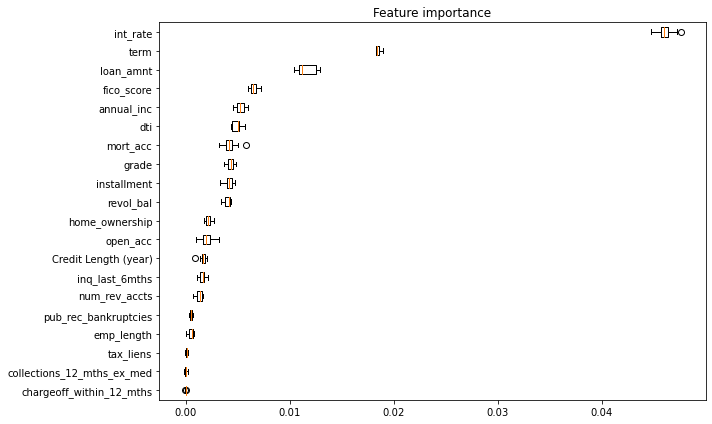

In [107]:
from sklearn.inspection import permutation_importance
result = permutation_importance(grid_search.best_estimator_, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(10,6))
ax.boxplot(
    result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx]
)
ax.set_title("Feature importance")
fig.tight_layout()
plt.show()



Text(0, 0.5, 'Feature Name')

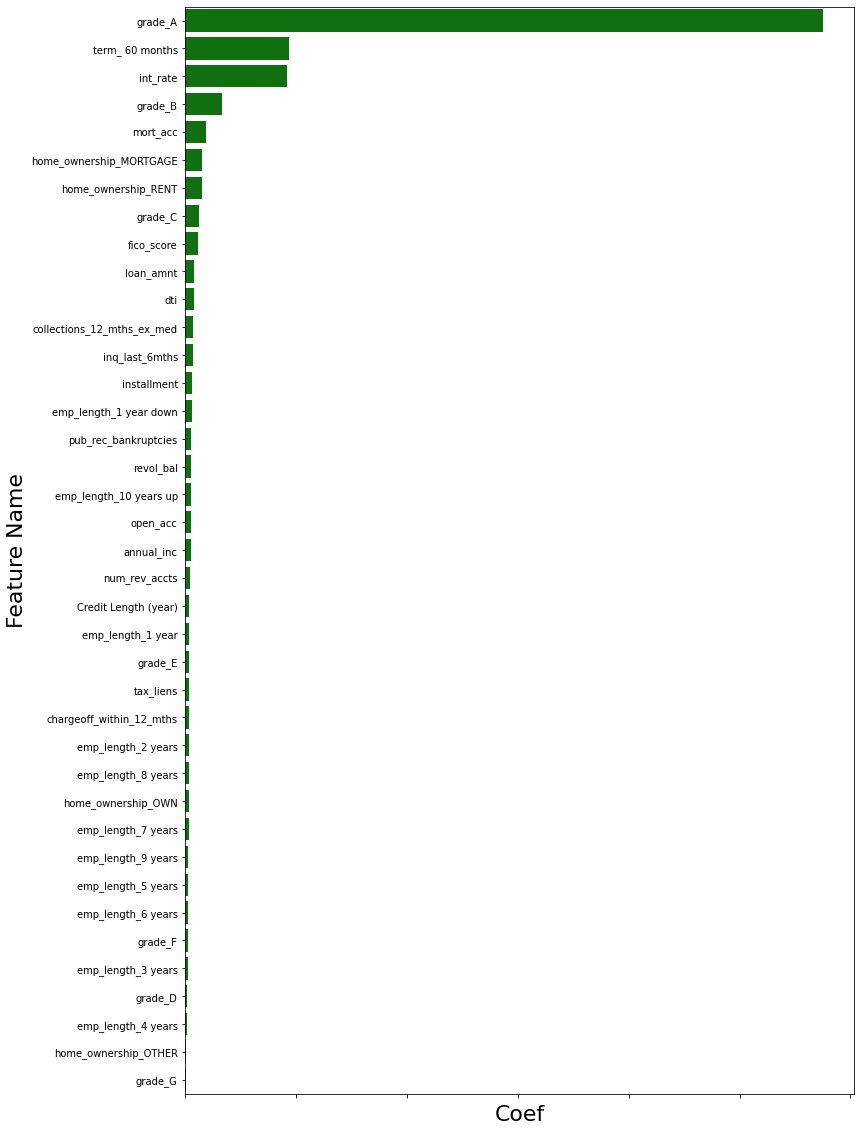

In [141]:
cat_cols = grid_search.best_estimator_.named_steps['preprocess'].named_transformers_['cat'].named_steps['encoder'].get_feature_names_out() 
num_cols = grid_search.best_estimator_.named_steps['preprocess'].named_transformers_['num'].named_steps['scaler'].get_feature_names_out()
all_cols = np.concatenate([cat_cols, num_cols])
coefs = grid_search.best_estimator_.named_steps['classifier'].feature_importances_.flatten()


coef = pd.DataFrame(zip(all_cols, coefs), columns=["feature", "coef"])
coef["abs_coef"] = coef["coef"].apply(lambda x: abs(x))
coef["colors"] = coef["coef"].apply(lambda x: "green" if x > 0 else "red")
coef = coef.sort_values("abs_coef", ascending=False)


fig, ax = plt.subplots(1, 1, figsize=(12, 20))
sns.barplot(y="feature",
            x="coef",
            data=coef,
           palette=coef["colors"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)

ax.set_xlabel("Coef", fontsize=22)
ax.set_ylabel("Feature Name", fontsize=22)



In [145]:
coefs

,Importance
feature,
grade_A,0.574848
term_ 60 months,0.033602
int_rate,0.013073
grade_B,0.002260
mort_acc,0.003731
home_ownership_MORTGAGE,0.002576
home_ownership_RENT,0.001167
grade_C,0.093805
fico_score,0.003902


In [148]:
coefs = pd.DataFrame(grid_search.best_estimator_.named_steps['classifier'].feature_importances_.T)
coefs['feature'] = all_cols
coefs.columns=['Importance', 'feature']
coefs.index = coefs['feature']
coefs

,Importance,feature
feature,,
grade_A,0.574848,grade_A
grade_B,0.033602,grade_B
grade_C,0.013073,grade_C
grade_D,0.002260,grade_D
grade_E,0.003731,grade_E
grade_F,0.002576,grade_F
grade_G,0.001167,grade_G
term_ 60 months,0.093805,term_ 60 months
emp_length_1 year,0.003902,emp_length_1 year


Text(0, 0.5, 'Feature')

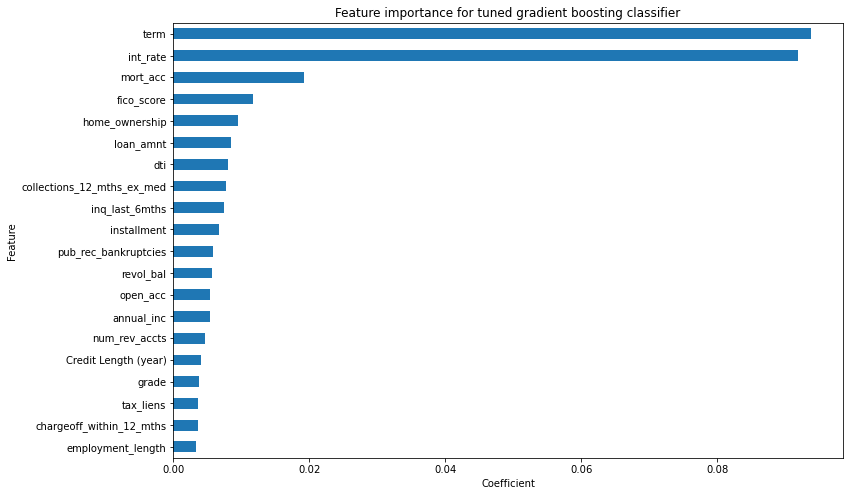

In [151]:
coefs = pd.DataFrame(grid_search.best_estimator_.named_steps['classifier'].feature_importances_.T)
coefs['feature'] = all_cols
coefs.columns=['Importance', 'feature']
coefs.index = coefs['feature']
coefs.drop(columns='feature', inplace=True)
home_ownership = coefs.loc['home_ownership_MORTGAGE':'home_ownership_RENT',:]
home_ownership  = pd.DataFrame({'Importance': home_ownership .median()})
home_ownership .index = ['home_ownership']

employment_length = coefs.loc['emp_length_1 year':'emp_length_9 years', :]
employment_length = pd.DataFrame({'Importance': employment_length.median()})
employment_length.index = ['employment_length']

grade = coefs.loc['grade_A':'grade_G', :]
grade = pd.DataFrame({'Importance': grade.median()})
grade.index = ['grade']

term = pd.DataFrame({'Importance': coefs.loc['term_ 60 months',:]})
term.index = ['term']

model_features = pd.concat([coefs.loc['dti':,:], term, home_ownership, employment_length, grade])
title = 'Feature importance for tuned gradient boosting classifier'

# Plot feature importance

fig, ax=plt.subplots()
model_features.sort_values(by='Importance').iloc[:, model_features.columns.get_loc('Importance')].plot(kind='barh', figsize=(12,8))
ax.set_title(title)
ax.set_xlabel('Coefficient')
ax.set_ylabel('Feature')

In [ ]:
from sklearn.tree import export_graphviz
from io import StringIO  
import os     
#import pydot
os.environ["PATH"] += os.pathsep + 'C://Users//somfl//anaconda3//Library//bin//graphviz'

# Now we want to visualize the tree
dot_data = StringIO()

# We can do so with export_graphviz
tree.export_graphviz(Tree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=X_train.columns,class_names = ['Fully Paid', 'Default'])
# Alternatively for class_names use entr_model.classes_
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
print(type(graph))
#graph, = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [193]:
df.head()

,dti,chargeoff_within_12_mths,collections_12_mths_ex_med,inq_last_6mths,open_acc,mort_acc,annual_inc,sub_grade,loan_status,installment,...,emp_length,home_ownership,num_rev_accts,pub_rec_bankruptcies,tax_liens,loan_amnt,Credit Length (year),fico_score,grade,status
revol_util,,,,,,,,,,,,,,,,,,,,,
29.7,5.91,0.0,0.0,1.0,7.0,1.0,55000.0,C4,Fully Paid,123.03,...,10 years up,MORTGAGE,9.0,0.0,0.0,3600.0,12.334271,677.0,C,0
19.2,16.06,0.0,0.0,4.0,22.0,4.0,65000.0,C1,Fully Paid,820.28,...,10 years up,MORTGAGE,27.0,0.0,0.0,24700.0,16.000329,717.0,C,0
64.5,25.37,0.0,0.0,3.0,12.0,6.0,104433.0,F1,Fully Paid,289.91,...,3 years,MORTGAGE,19.0,0.0,0.0,10400.0,17.500702,697.0,F,0
68.4,10.20,0.0,0.0,0.0,5.0,0.0,34000.0,C3,Fully Paid,405.18,...,4 years,RENT,4.0,0.0,0.0,11950.0,28.167587,692.0,C,0
84.5,14.67,0.0,0.0,0.0,12.0,4.0,180000.0,B2,Fully Paid,637.58,...,10 years up,MORTGAGE,16.0,0.0,0.0,20000.0,25.500866,682.0,B,0


In [194]:
df['status'].value_counts()

0    1004408
1     271289
Name: status, dtype: int64

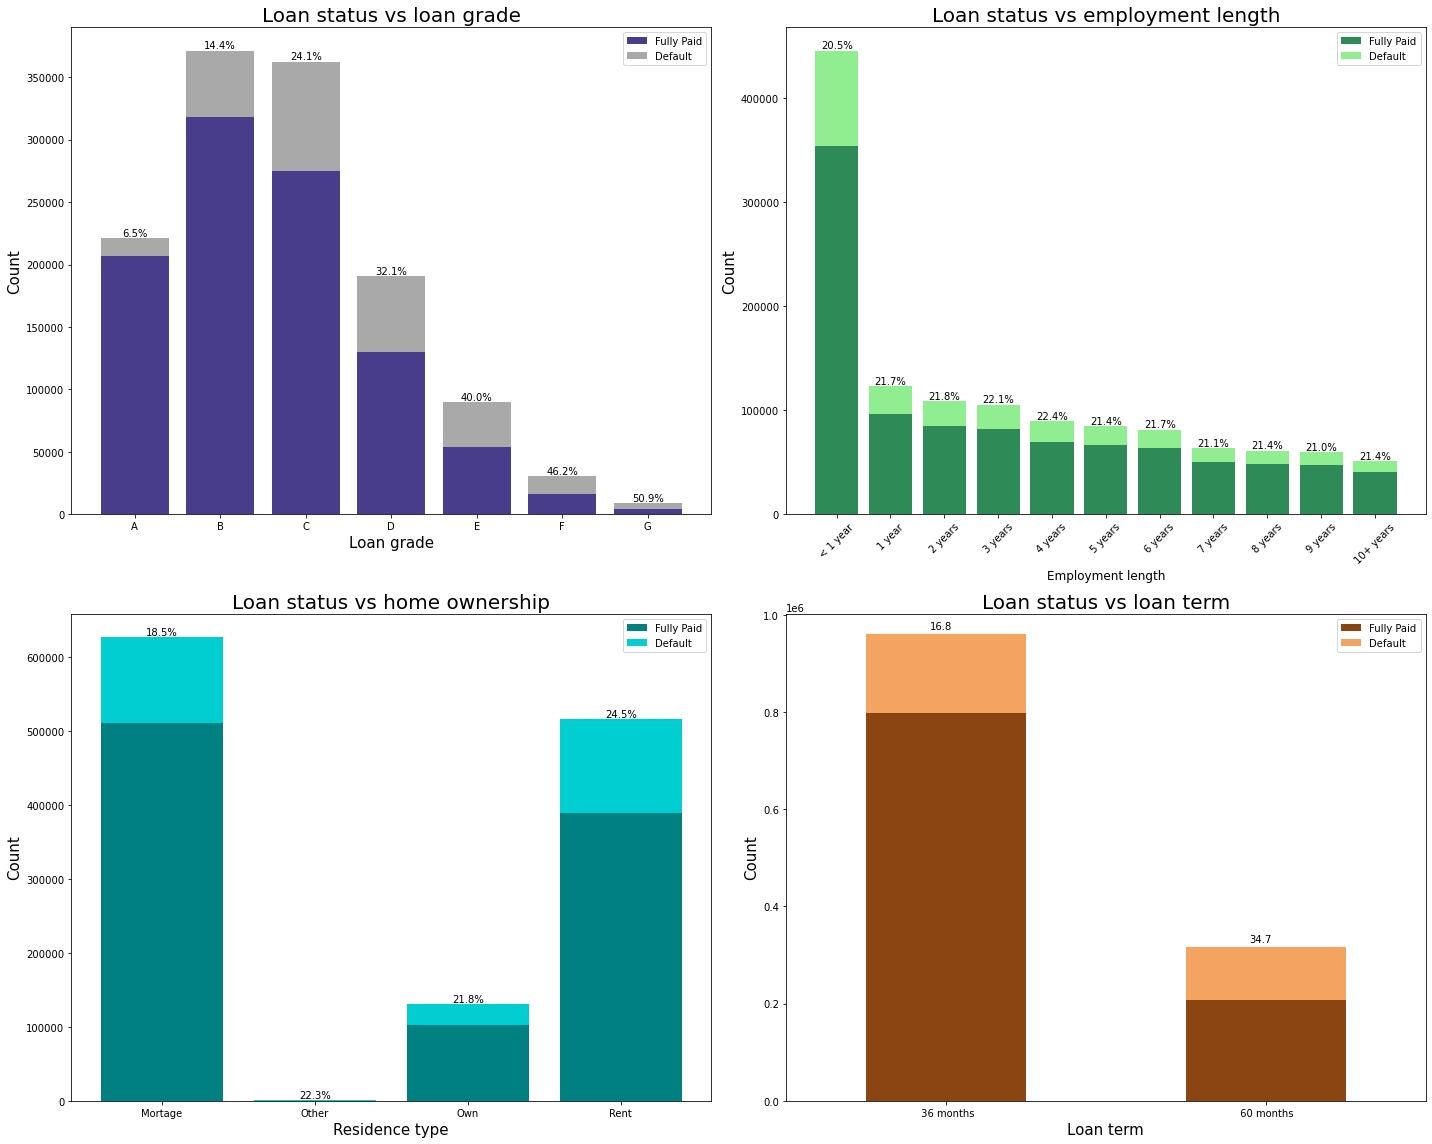

In [223]:
fig, [(ax0, ax1), (ax2, ax3)] = plt.subplots(nrows = 2, ncols = 2, figsize=(20,16))

### ax0
s = pd.DataFrame({'Fully Paid': df.loc[df['status']==0, 'grade'].value_counts(), 'Default': df.loc[df['status']==1, 'grade'].value_counts()})
s['Total'] = s['Default'] + s['Fully Paid']
s.index=[ 'A', 'B', 'C', 'D', 'E', 'F', "G"]

ax0.bar(s.index, s['Fully Paid'], color="darkslateblue")
ax0.bar(s.index, s['Default'], bottom=s['Fully Paid'], color='darkgrey')
ax0.set_xticklabels(s.index, rotation=0)
ax0.legend(['Fully Paid', 'Default'])
ax0.set_xlabel('Loan grade', fontsize=15)
ax0.set_ylabel('Count', fontsize=15)
ax0.set_title("Loan status vs loan grade", fontsize=20)


s_total=s['Total']
s = s.iloc[:, 0:2]

s_rel = s.div(s_total, 0)*100

n = 'Default'
for i, (cs, pc) in enumerate(zip(s.cumsum(1)[n], s_rel[n])):
    ax0.text(i, cs, str(np.round(pc, 1)) + '%', va='bottom', ha='center')


    
    
#### ax1    
    
s = pd.DataFrame({'Fully Paid': df.loc[df['status']==0, 'emp_length'].value_counts(), 'Default': df.loc[df['status']==1, 'emp_length'].value_counts()})
listIndex = s.index


s.index = ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', '6 years',
    '7 years', '8 years', '9 years', '10+ years']

s['Total'] = s['Default'] + s['Fully Paid']

ax1.bar(s.index, s['Fully Paid'], color='seagreen')
ax1.bar(s.index, s['Default'], bottom=s['Fully Paid'], color='lightgreen')
ax1.set_xticklabels(s.index, rotation=45)
ax1.legend(['Fully Paid', 'Default'])
ax1.set_xlabel('Employment length', fontsize=12)
ax1.set_ylabel('Count', fontsize=15)
ax1.set_title("Loan status vs employment length", fontsize=20)


s_total=s['Total']
s = s.iloc[:, 0:2]
s_rel = s.div(s_total, 0)*100

n = 'Default'
for i, (cs, pc) in enumerate(zip(s.cumsum(1)[n], s_rel[n])):
    ax1.text(i, cs, str(np.round(pc, 1)) + '%', va='bottom', ha='center')
    
### ax2
s = pd.DataFrame({'Fully Paid': df.loc[df['status']==0, ['home_ownership']].value_counts(), 'Default': df.loc[df['status']==1, ['home_ownership']].value_counts()})
s['Total'] = s['Default'] + s['Fully Paid']
s.index=[ 'Mortage', 'Other', 'Own', 'Rent']

ax2.bar(s.index, s['Fully Paid'], color="teal")
ax2.bar(s.index, s['Default'], bottom=s['Fully Paid'], color='darkturquoise')
ax2.set_xticklabels(s.index, rotation=0)
ax2.legend(['Fully Paid', 'Default'])
ax2.set_xlabel('Residence type', fontsize=15)
ax2.set_ylabel('Count', fontsize=15)
ax2.set_title("Loan status vs home ownership", fontsize=20)


s_total=s['Total']
s = s.iloc[:, 0:2]

s_rel = s.div(s_total, 0)*100

n = 'Default'
for i, (cs, pc) in enumerate(zip(s.cumsum(1)[n], s_rel[n])):
    ax2.text(i, cs, str(np.round(pc, 1)) + '%', va='bottom', ha='center')

           
    
    

### ax3    
s4 = pd.DataFrame({'Fully Paid': df.loc[df['status']==0, ['term']].value_counts(), 'Default': df.loc[df['status']==1, ['term']].value_counts()})
listIndex = s4.index

new = []
for item in listIndex:
    new.append(''.join(item))
s4.index = new

s4.plot.bar(stacked=True, ax=ax3, color=["saddlebrown", "sandybrown"])



ax3.legend(['Fully Paid', 'Default'])
ax3.set_xlabel('Loan term', fontsize=15)
ax3.set_ylabel('Count', fontsize=15)
ax3.set_ylim(0,1002000)
ax3.set_title("Loan status vs loan term", fontsize=20) 
ax3.set_xticklabels(s4.index, rotation=0)
p = ax3.patches
for i in range(0,2,1):
    x1, y1 = p[i].get_xy()
    x2, y2 = p[i+1].get_xy()
    x = x1 +0.2
    Y1 = p[i].get_height()
    Y2 = p[i+2].get_height()
    y = Y2 + Y1 +10000
    a = Y2/(Y2 + Y1)
    ax3.text(x, y, round(a*100,1), rotation=0)

fig.tight_layout()